# Import Libraries & Load Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.compose import ColumnTransformer
from tensorflow.keras.layers import Dense

# Load the data
df = pd.read_csv('dataset.csv')
df.head()

,market_id,created_at,actual_delivery_time,store_id,store_primary_category,order_protocol,total_items,subtotal,num_distinct_items,min_item_price,max_item_price,total_onshift_partners,total_busy_partners,total_outstanding_orders
0,1.0,2015-02-06 22:24:17,2015-02-06 23:27:16,df263d996281d984952c07998dc54358,american,1.0,4,3441,4,557,1239,33.0,14.0,21.0
1,2.0,2015-02-10 21:49:25,2015-02-10 22:56:29,f0ade77b43923b38237db569b016ba25,mexican,2.0,1,1900,1,1400,1400,1.0,2.0,2.0
2,3.0,2015-01-22 20:39:28,2015-01-22 21:09:09,f0ade77b43923b38237db569b016ba25,NaN,1.0,1,1900,1,1900,1900,1.0,0.0,0.0
3,3.0,2015-02-03 21:21:45,2015-02-03 22:13:00,f0ade77b43923b38237db569b016ba25,NaN,1.0,6,6900,5,600,1800,1.0,1.0,2.0
4,3.0,2015-02-15 02:40:36,2015-02-15 03:20:26,f0ade77b43923b38237db569b016ba25,NaN,1.0,3,3900,3,1100,1600,6.0,6.0,9.0


# Exploratory Data Analysis (EDA)

In [2]:
# Check data structure
print(df.info())

# Summary statistics
print(df.describe())

# Check missing values
print("Missing values:\n", df.isnull().sum())

# Unique categories in categorical columns
print("Unique store categories:", df['store_primary_category'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197428 entries, 0 to 197427
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   market_id                 196441 non-null  float64
 1   created_at                197428 non-null  object 
 2   actual_delivery_time      197421 non-null  object 
 3   store_id                  197428 non-null  object 
 4   store_primary_category    192668 non-null  object 
 5   order_protocol            196433 non-null  float64
 6   total_items               197428 non-null  int64  
 7   subtotal                  197428 non-null  int64  
 8   num_distinct_items        197428 non-null  int64  
 9   min_item_price            197428 non-null  int64  
 10  max_item_price            197428 non-null  int64  
 11  total_onshift_partners    181166 non-null  float64
 12  total_busy_partners       181166 non-null  float64
 13  total_outstanding_orders  181166 non-null  f

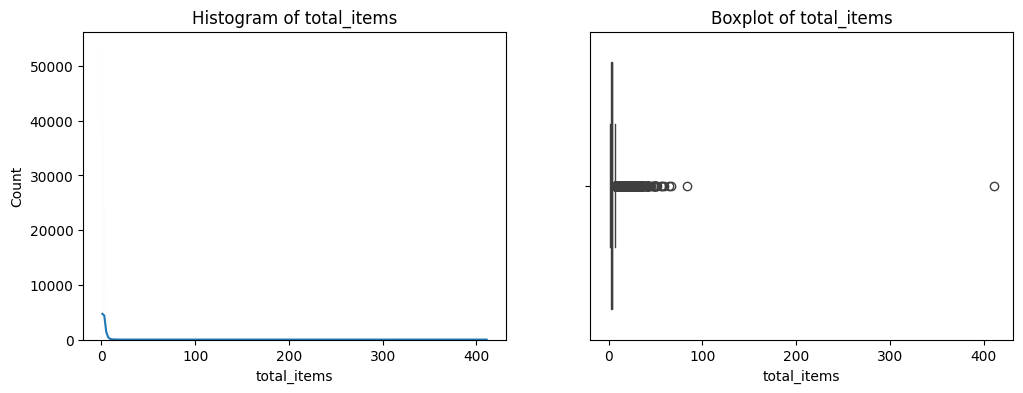

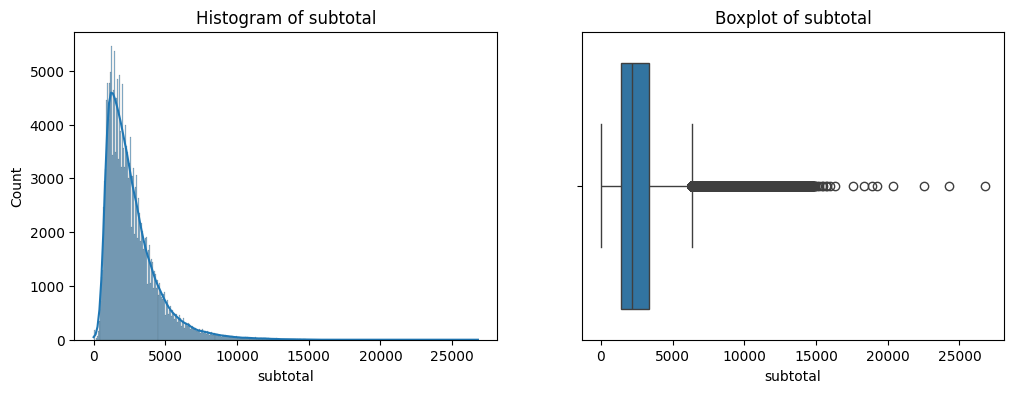

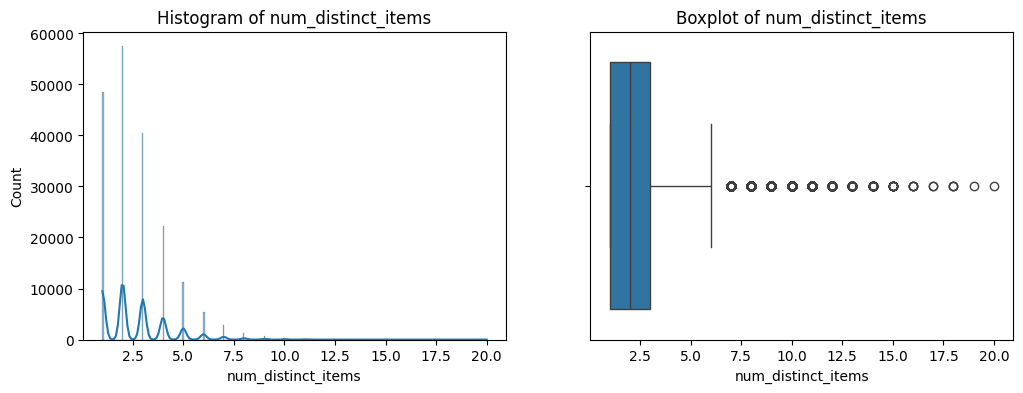

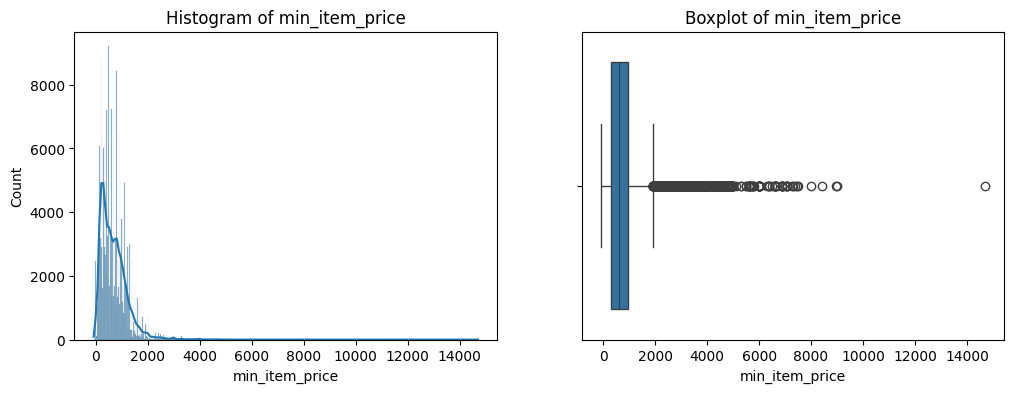

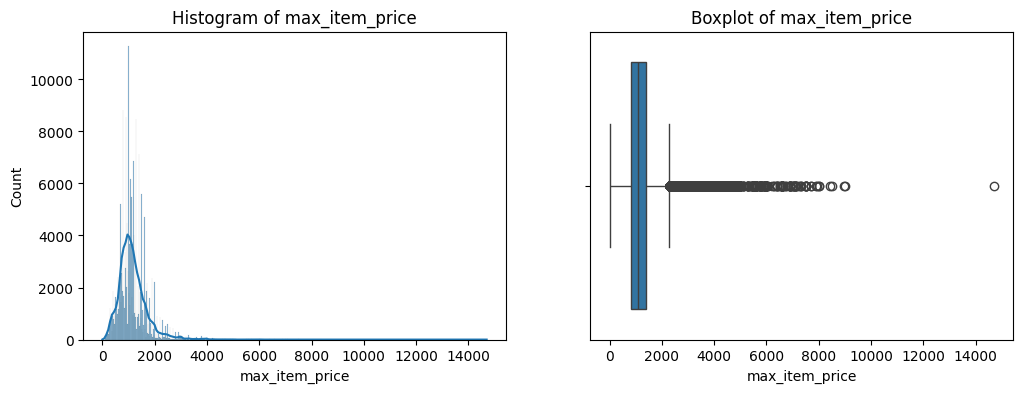

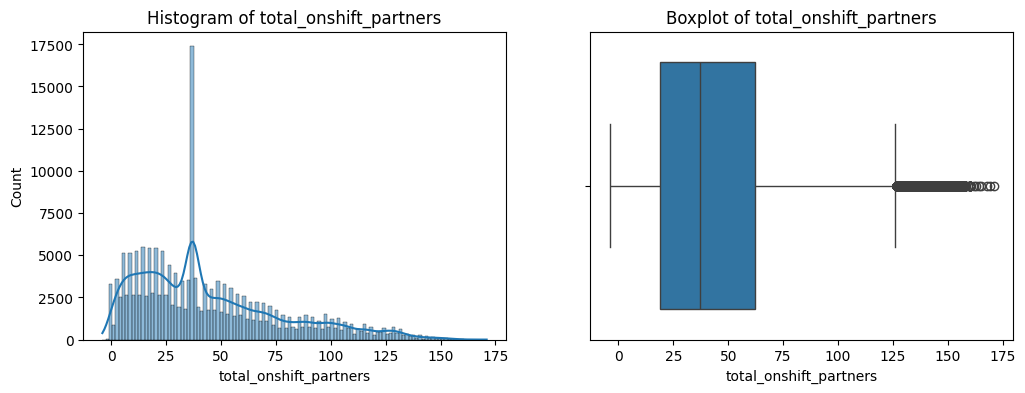

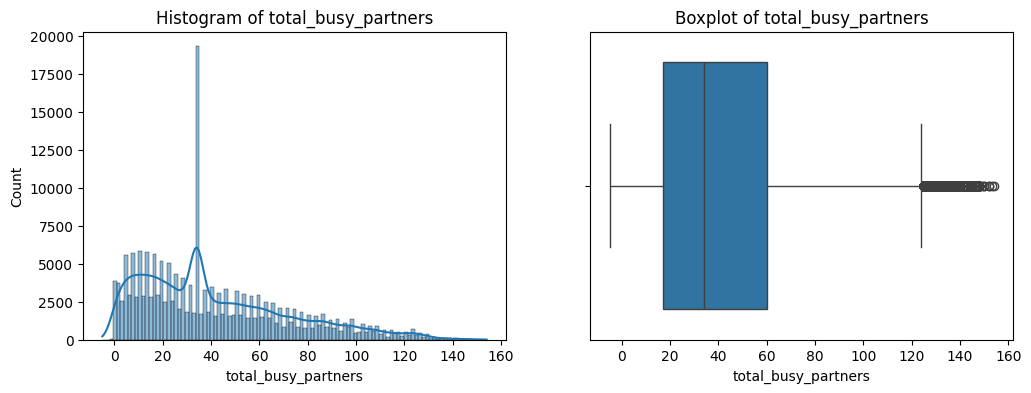

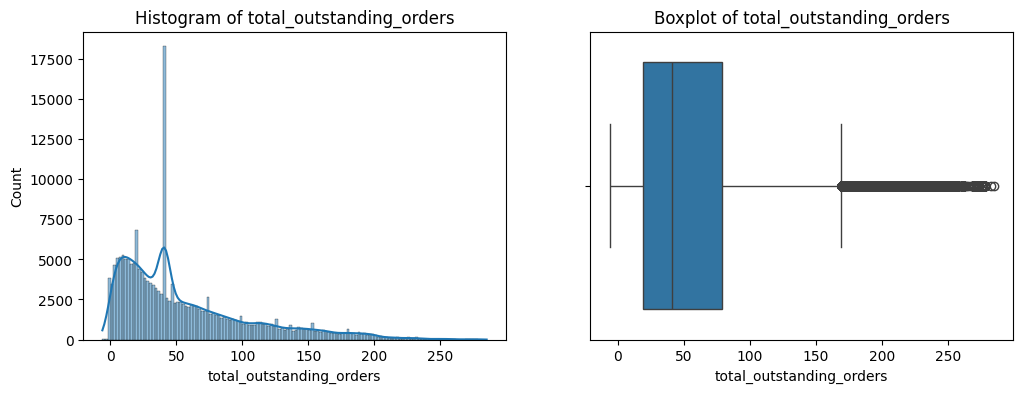

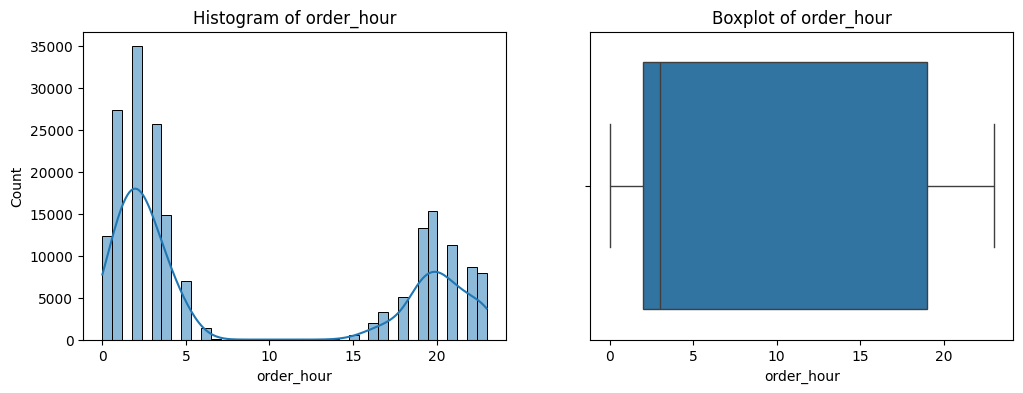

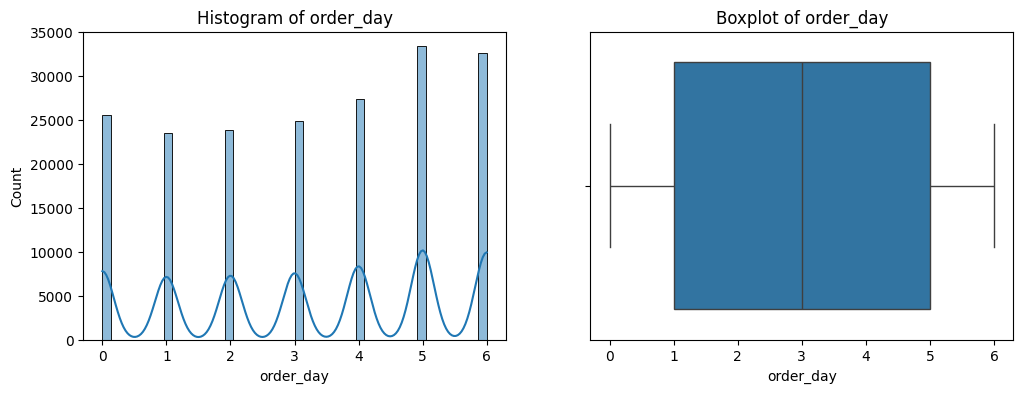

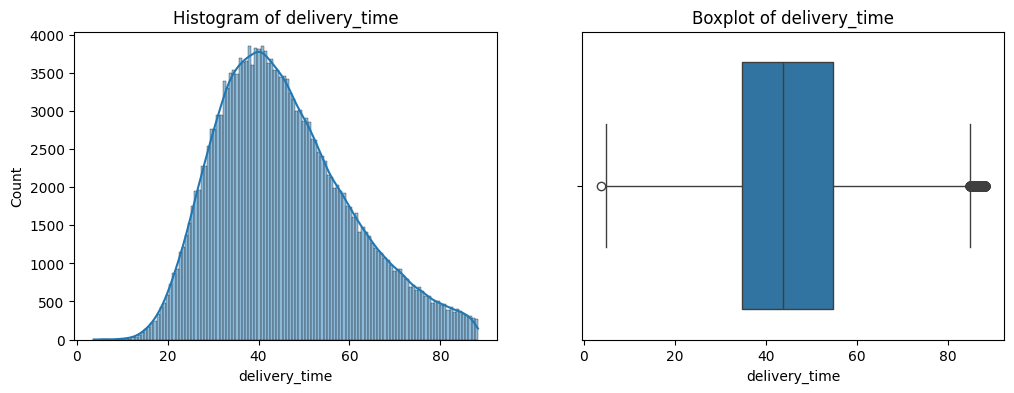

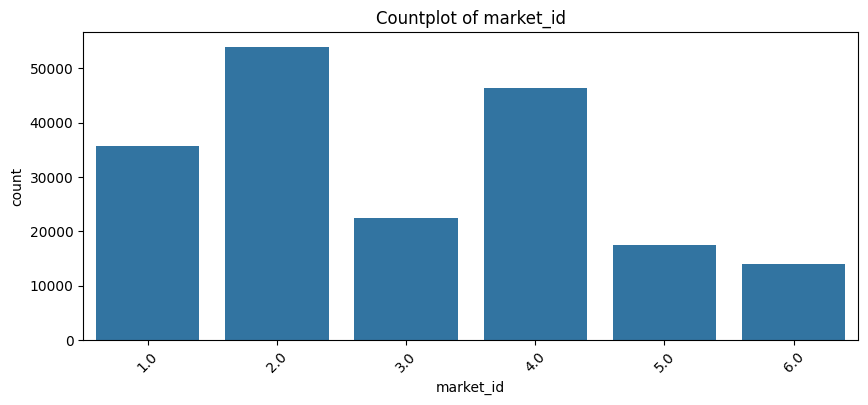

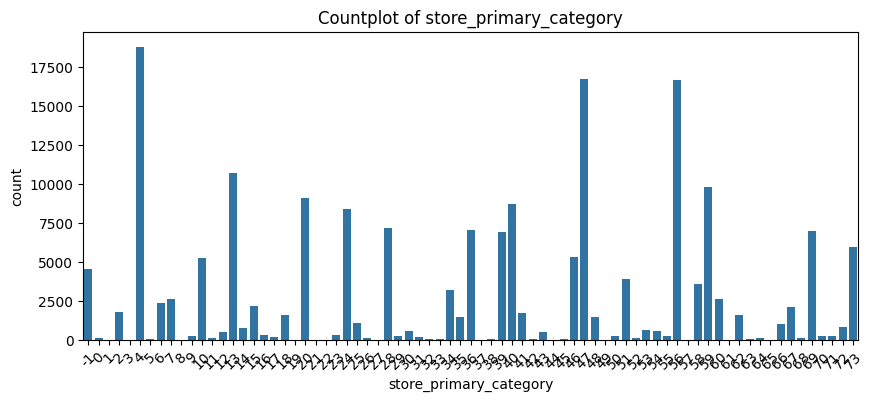

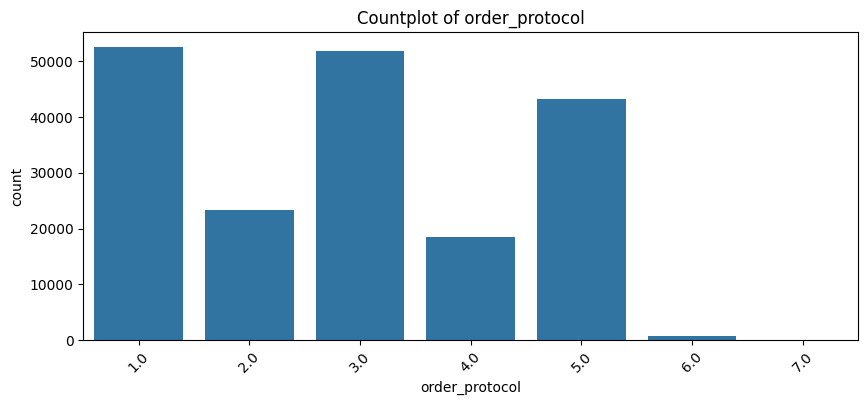

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define numerical and categorical features
numerical_features = ['total_items', 'subtotal', 'num_distinct_items',
                      'min_item_price', 'max_item_price', 'total_onshift_partners',
                      'total_busy_partners', 'total_outstanding_orders',
                      'order_hour', 'order_day', 'delivery_time']
categorical_features = ['market_id', 'store_primary_category', 'order_protocol']

# Plot numerical features
for feature in numerical_features:
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    sns.histplot(df[feature], kde=True)
    plt.title(f'Histogram of {feature}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[feature])
    plt.title(f'Boxplot of {feature}')
    plt.show()

# Plot categorical features
for feature in categorical_features:
    plt.figure(figsize=(10, 4))
    if feature == 'market_id':
        # Show top 10 markets
        top_markets = df[feature].value_counts().nlargest(10).index
        df_top = df[df[feature].isin(top_markets)]
        sns.countplot(x=feature, data=df_top)
    else:
        sns.countplot(x=feature, data=df)
    plt.title(f'Countplot of {feature}')
    plt.xticks(rotation=45)
    plt.show()

# Feature Engineering

In [3]:
# Convert timestamp columns to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['actual_delivery_time'] = pd.to_datetime(df['actual_delivery_time'])

# Create target variable (delivery time in minutes)
df['delivery_time'] = (df['actual_delivery_time'] - df['created_at']).dt.total_seconds() / 60

# Extract hour and day of week
df['order_hour'] = df['created_at'].dt.hour
df['order_day'] = df['created_at'].dt.dayofweek

# Handle categorical variables
df['store_primary_category'] = pd.Categorical(df['store_primary_category']).codes

# Check for null values
print(df.isnull().sum())

market_id                     987
created_at                      0
actual_delivery_time            7
store_id                        0
store_primary_category          0
order_protocol                995
total_items                     0
subtotal                        0
num_distinct_items              0
min_item_price                  0
max_item_price                  0
total_onshift_partners      16262
total_busy_partners         16262
total_outstanding_orders    16262
delivery_time                   7
order_hour                      0
order_day                       0
dtype: int64


# Handle Missing Values

In [4]:
# Impute numerical columns with median
num_cols = ['total_onshift_partners', 'total_busy_partners', 'total_outstanding_orders']
for col in num_cols:
    df[col] = df[col].fillna(df[col].median())

# Fill categorical columns with 'Unknown'
cat_cols = ['store_primary_category']
df[cat_cols] = df[cat_cols].fillna('Unknown')

# Encode Categorical Features

In [5]:
# Import necessary libraries
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
# Define categorical and numerical features
categorical_features = ['market_id', 'store_primary_category', 'order_protocol']
numerical_features = ['total_items', 'subtotal', 'num_distinct_items',
                      'min_item_price', 'max_item_price', 'total_onshift_partners',
                      'total_busy_partners', 'total_outstanding_orders',
                      'order_hour', 'order_day']

# Use ColumnTransformer for encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ])

# Apply transformations
X = df.drop('delivery_time', axis=1)
y = df['delivery_time']
X_processed = preprocessor.fit_transform(X)

# Outlier Detection & Removal

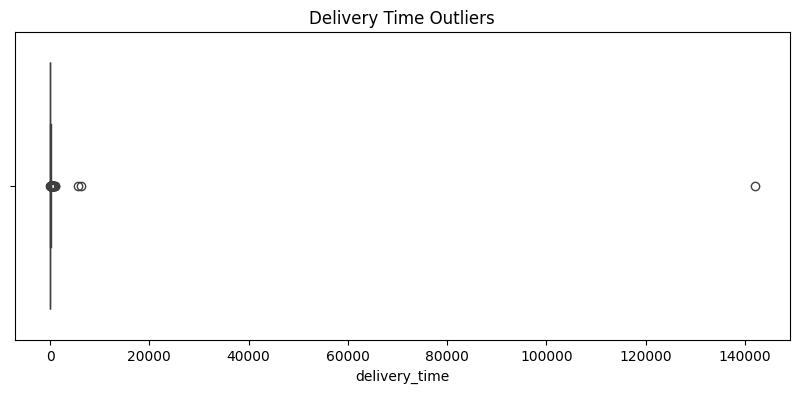

In [6]:
# Plot boxplot for delivery time
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['delivery_time'])
plt.title("Delivery Time Outliers")
plt.show()

# Remove outliers using IQR
Q1 = df['delivery_time'].quantile(0.25)
Q3 = df['delivery_time'].quantile(0.75)
IQR = Q3 - Q1
df = df[(df['delivery_time'] >= Q1 - 1.5*IQR) &
        (df['delivery_time'] <= Q3 + 1.5*IQR)]

# Split Data into Train/Test Sets

In [7]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)
print("Training shape:", X_train.shape)
print("Testing shape:", X_test.shape)

Training shape: (157942, 100)
Testing shape: (39486, 100)


# Build & Train Neural Network

Checking NaN values in features:
market_id                   0
store_primary_category      0
order_protocol              0
total_items                 0
subtotal                    0
num_distinct_items          0
min_item_price              0
max_item_price              0
total_onshift_partners      0
total_busy_partners         0
total_outstanding_orders    0
order_hour                  0
order_day                   0
dtype: int64

Checking NaN values in target:
0
Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


3794/3794 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 440.0865 - mae: 15.5926 - val_loss: 179.4315 - val_mae: 10.4932
Epoch 2/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 195.0731 - mae: 11.0530 - val_loss: 182.5258 - val_mae: 10.4744
Epoch 3/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 187.7186 - mae: 10.8732 - val_loss: 177.2603 - val_mae: 10.3906
Epoch 4/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step - loss: 184.6445 - mae: 10.7735 - val_loss: 176.3089 - val_mae: 10.4135
Epoch 5/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 182.6427 - mae: 10.7165 - val_loss: 175.2968 - val_mae: 10.4108
Epoch 6/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 178.6758 - mae: 10.6013 - val_loss: 189.0352 - val_mae: 10.5575
Epoch 7/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 178.8369 - mae: 10.6078 - val_loss: 182.9107 - val_mae: 10.4243
Epoch 8/100
3794/3794 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 177.1358 - mae: 10.5647 - val_loss: 178.2231 - val_m

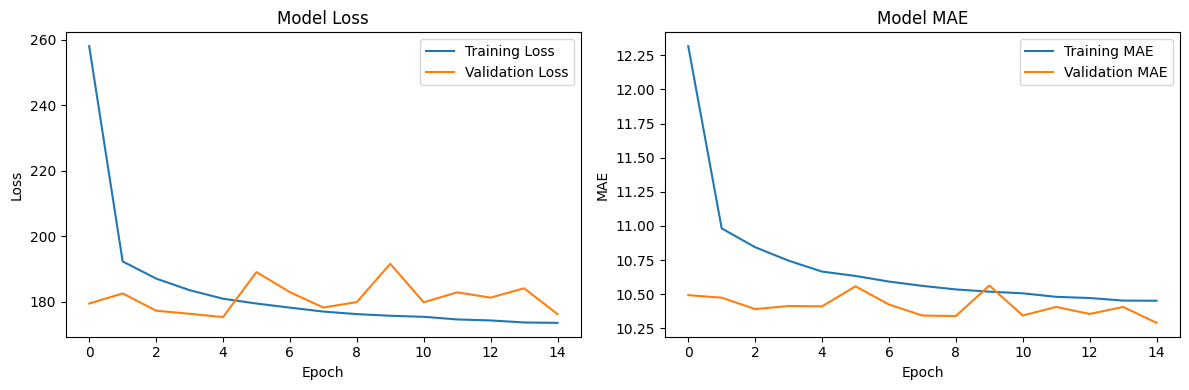

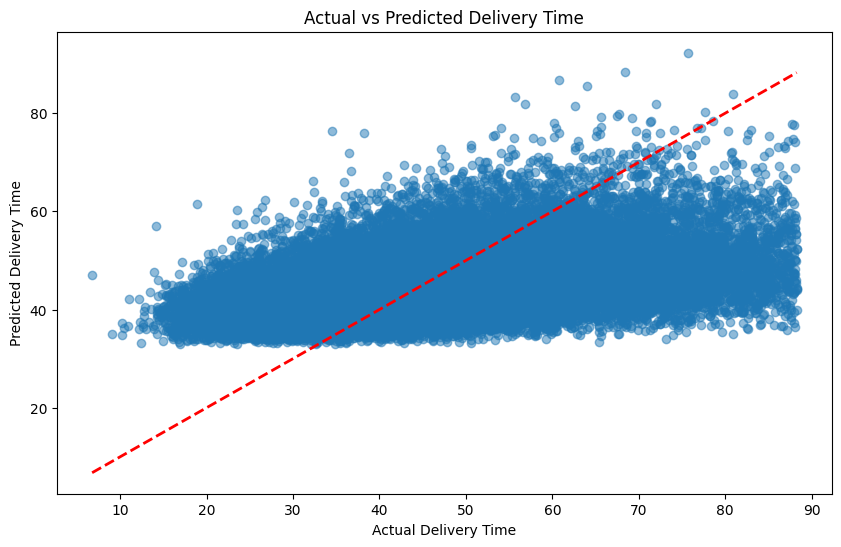

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. First, let's check where the NaN values are coming from
print("Checking NaN values in features:")
print(X.isna().sum())
print("\nChecking NaN values in target:")
print(y.isna().sum())

# 2. Clean the data by removing rows with NaN values
df_clean = df.dropna()

# 3. Prepare the clean data
features = ['market_id', 'store_primary_category', 'order_protocol',
           'total_items', 'subtotal', 'num_distinct_items',
           'min_item_price', 'max_item_price', 'total_onshift_partners',
           'total_busy_partners', 'total_outstanding_orders',
           'order_hour', 'order_day']

X = df_clean[features]
y = df_clean['delivery_time']

# 4. Split the clean data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Create and train the neural network
model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=(len(features),)),
    layers.Dropout(0.2),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    patience=10,
    min_delta=0.001,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train_scaled, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# 7. Make predictions
train_predictions = model.predict(X_train_scaled)
test_predictions = model.predict(X_test_scaled)

# 8. Calculate metrics
train_mse = mean_squared_error(y_train, train_predictions)
test_mse = mean_squared_error(y_test, test_predictions)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)
test_r2 = r2_score(y_test, test_predictions)

print("\nModel Performance Metrics:")
print(f"Train RMSE: {train_rmse:.2f} minutes")
print(f"Test RMSE: {test_rmse:.2f} minutes")
print(f"Train MAE: {train_mae:.2f} minutes")
print(f"Test MAE: {test_mae:.2f} minutes")
print(f"Test R² Score: {test_r2:.3f}")

# 9. Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

# 10. Visualize predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, test_predictions, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time')
plt.show()


# Hyperparameter Tuning

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_model(hidden_units=64, learning_rate=0.001, dropout_rate=0.2):
    model = keras.Sequential([
        Dense(hidden_units, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(dropout_rate),
        Dense(hidden_units//2, activation='relu'),
        Dense(1)
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    return model

# Try different hyperparameters
params = [
    {'hidden_units': 32, 'learning_rate': 0.01, 'dropout_rate': 0.1},
    {'hidden_units': 64, 'learning_rate': 0.001, 'dropout_rate': 0.3},
    {'hidden_units': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.5}
]

for param in params:
    print(f"Training with: {param}")
    model = build_model(**param)
    history = model.fit(
        X_train_scaled, y_train,
        epochs=50,
        batch_size=32,
        validation_split=0.2,
        callbacks=[EarlyStopping(patience=5)],
        verbose=0
    )
    val_mae = min(history.history['val_mae'])
    print(f"Best Validation MAE: {val_mae:.2f}\n")

Training with: {'hidden_units': 32, 'learning_rate': 0.01, 'dropout_rate': 0.1}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation MAE: 10.18

Training with: {'hidden_units': 64, 'learning_rate': 0.001, 'dropout_rate': 0.3}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation MAE: 10.19

Training with: {'hidden_units': 128, 'learning_rate': 0.0001, 'dropout_rate': 0.5}


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Best Validation MAE: 10.35



# Questions And Answers:

1. Defining the problem statement and where can this and modifications of this be used?

- Problem Statement: Predict delivery time (in minutes) using features like order details, partner availability, and time of order to improve customer experience and operational efficiency.

- Modifications:

    Dynamic Pricing: Surge pricing during peak hours.

    Route Optimization: Assign orders to drivers based on predicted time.

    Demand Forecasting: Predict order volume to pre-allocate drivers.

2. List 3 functions the pandas datetime provides with one line explanation.

- dt.hour: Extracts the hour (0-23) from a datetime column.
df['order_hour'] = df['created_at'].dt.hour  # Used in feature engineering

- dt.dayofweek: Returns the day of the week (0=Monday, 6=Sunday).
df['order_day'] = df['created_at'].dt.dayofweek

- dt.total_seconds(): Converts a timedelta (duration) to total seconds.
df['delivery_time_minutes'] = (delivery_time).dt.total_seconds() / 60

3. Short note on datetime, timedelta, time span

- datetime: Represents a specific moment (e.g., 2023-10-25 14:30:00).

- timedelta: Represents a duration (e.g., 30 minutes between order and delivery).

- period: Represents a time span (e.g., "October 2023").

4. Why do we need to check for outliers in our data?

- Outliers distort statistical assumptions and model training:

- Impact on Neural Networks: Outliers cause large loss values, leading to unstable gradients.

- Business Impact: Unrealistic delivery times (e.g., negative or 10-hour deliveries) mislead the model.

5. Name 3 outlier removal methods?

- IQR Method: Remove data outside [Q1 - 1.5*IQR, Q3 + 1.5*IQR].

    Q1 = df['delivery_time_minutes'].quantile(0.25)

    Q3 = df['delivery_time_minutes'].quantile(0.75)

    df = df[(df['delivery_time_minutes'] >= Q1 - 1.5*IQR) & (df['delivery_time_minutes'] <= Q3 + 1.5*IQR)]
  
- Z-Score: Remove data beyond ±3 standard deviations.

- Clipping: Cap values at a threshold (e.g., max delivery time = 2 hours).

6. What classical machine learning methods can we use for this problem?

- Linear Regression: Baseline for understanding feature relationships.

- Random Forest: Handles non-linear relationships and feature interactions.

- XGBoost: Gradient boosting for high accuracy with hyperparameter tuning.

7. Why is scaling required for neural networks?

- Gradient Descent: Features on different scales (e.g., subtotal in 100s vs order_hour in 0-23) cause uneven updates.

- Convergence Speed: Scaled data (e.g., using StandardScaler) helps the optimizer converge faster.

8. Briefly explain your choice of optimizer.

- Adam (Adaptive Moment Estimation) is used because:

    Adaptive Learning Rates: Adjusts rates per-parameter (useful for sparse gradients).

    Efficiency: Combines benefits of AdaGrad (for sparse data) and RMSProp (for online learning).

9. Which activation function did you use and why?

- Hidden Layers: ReLU (relu) avoids vanishing gradients and speeds up training compared to sigmoid/tanh.

- Output Layer: Linear activation (no activation) for regression tasks.

10. Why does a neural network perform well on a large dataset?

- Capacity: Deep networks learn hierarchical patterns (e.g., time + partner availability → delivery time).

- Generalization: Large datasets reduce overfitting by exposing the model to diverse scenarios.

